# Probability density fitting of a Mixture of Gaussians via autograd

Recently I've had to fit a [Mixture of two Gaussians](https://en.wikipedia.org/wiki/Mixture_model#Gaussian_mixture_model) to a target *density* instead of individual samples drawn from this density.
Googling revealed that at least [one other person](https://stats.stackexchange.com/questions/226504/fit-gaussian-mixture-model-directly-to-the-mixture-density) faced this particular problem too, but there was no code readily available.

To be clear, the problem is the following: given a mixture of Gaussian probability density that is evaluated at $N$ points, we want to recover parameters of these Gaussians (i.e. mean $\mu_{i}$, standard deviation $\sigma_{i}$, and a set of mixture weights $\pi_{i}$ that are constrained to be [0, 1] and sum to 1).

For three Gaussians our objective is to find parameters of a Gaussian mixture that make its density match the blue line below (evaluated at $N=25$ points).

Text(0, 0.5, 'Density')

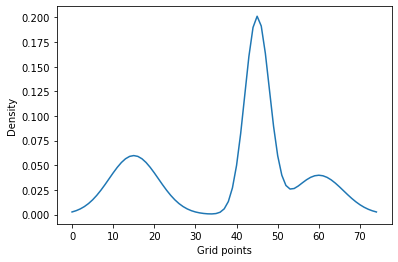

In [38]:
from scipy import stats
import autograd.numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
true_means = [5, 15, 20]
true_stds = [2, 1, 2]
true_pis = [0.3, 0.5, 0.2]

gridmin, gridmax, N = 0, 25, 75
grid =  np.arange(gridmin, gridmax, (gridmax-gridmin)/N)

data = np.array([
    np.sum([pi*stats.norm.pdf(t, loc=m, scale=std)
            for m, std, pi in zip(true_means, true_stds, true_pis)])
                for t in grid])
plt.plot(data, label='Mixture probability density')
plt.xlabel('Grid points')
plt.ylabel('Density')

What follows is my simple solution using autograd with the following caveats:
* I estimate the distance between target probability density and our density via an $L2$ distance
* Placing a prior on individual parameters will help in converging to a sensible solution (i.e. prevent standard deviation from exploding)
* Initial parameters matter, it can be necessary to run the procedure multiple times and choose the solution with smallest loss

## The solution

In [41]:
import autograd.numpy as np
from autograd import grad
from autograd import hessian_vector_product
from autograd.misc.flatten import flatten_func
from functools import partial

# we have to defince our own Gaussian pdf because autograd does not like the one provided by scipy
def pdf(x, m, std):
    return (1/(std*np.sqrt(2*np.pi)))*np.exp(-0.5*((x-m)/std)**2)

def gmm(t, means, stds, pis):
    '''Returns the density of a mixture of Gaussians model estimated at grid point t.
    means is a list of means of the gaussians
    stds are logarithms of the standard deviation of the gaussians
    pis is the mixing probability'''
    density = np.sum([pi*pdf(t, mean, np.exp(std))
                      for mean, std, pi in zip(means, stds, pis)])
    return density

def loss_func(target_density, nested_params, grid=25):
    '''Loss function for the model,
    target_density is an array of values for the target density,
    params is a list that contains m1, m2, std1, std2 and the logit of pi,
    grid can either be an int (in which case it is the argument supplied to range) or an iterable'''
    means, stds, pis = nested_params
    if type(grid)==int:
        grid = range(grid)
    # go from logits to probabilities
    pis = [np.exp(pi) for pi in pis]
    pis = [pi/np.sum(pis) for pi in pis]
    our_density = np.array([gmm(t, means, stds, pis)
                for t in grid])
    return np.sum((target_density-our_density)**2)

# use partial to build a loss function that uses our data and grid structure
objective = partial(loss_func, data, grid=grid)

# get a random guess for the mean
randmean = np.random.randint(0, 25, 3).astype('float').tolist()
initial_params = [randmean, [0., 0., 0.], [5., 5., 5.]]

# flatten everything so it plays nice with the optimizer
flattened_obj, unflatten, flattened_init_params =\
        flatten_func(objective, initial_params)

# get jacobian
gradf = grad(flattened_obj)

# now use conjugate gradient descent
from scipy.optimize import minimize
res=minimize(flattened_obj, flattened_init_params,
         jac=gradf, method='BFGS')

means, stds, pis = unflatten(res.x)
pis = [np.exp(pi) for pi in pis]
pis = [pi/np.sum(pis) for pi in pis]

print('True parameters {}'.format(true_means+true_stds+true_pis))
print('Recovered parameters {}'.format(means+[np.exp(std) for std in stds]+pis))

True parameters [5, 15, 20, 2, 1, 2, 0.3, 0.5, 0.2]
Recovered parameters [array(5.00019487), array(20.0016879), array(15.00013811), 2.000017569259828, 1.99839559825986, 1.0001623730291136, 0.2999967947038737, 0.1999050817841846, 0.5000981235119417]


### Let's see if the results look right.

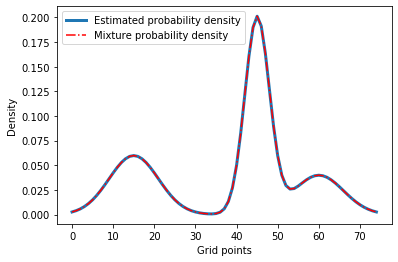

In [42]:
our_density = np.array([gmm(t, means, stds, pis)
                for t in grid])

plt.plot(our_density, label='Estimated probability density', linewidth=3)
plt.plot(data, 'r-.', label='Mixture probability density')
plt.xlabel('Grid points')
plt.ylabel('Density')
plt.legend()